# Experiment 3: K-Means after PCA
Run K-Means on PCA-reduced breast cancer data (components: 2, 5, 10, 15, 20) to study reconstruction error vs clustering quality. Metrics: silhouette, Davies-Bouldin, Calinski-Harabasz, WCSS, ARI, NMI, purity; plus confusion matrix for best silhouette and 2D projection.

In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
from PCA import PCA
import part3

sns.set(style="whitegrid")

In [2]:
# Load and standardize dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [3]:
# Run PCA -> KMeans across component counts

def run_pca_kmeans(
    X,
    y_true,
    n_components_list,
    k=2,
    init="kmeans++",
    max_iter=300,
    tol=1e-4,
):
    results = {
        "n_components": [],
        "reconstruction_error": [],
        "explained_variance": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "labels": [],
    }

    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp)
        pca.fit(X)
        X_pca = pca.transform(X)

        rec_err = pca.reconstruction_error(X)
        explained = np.sum(pca.explained_variance_ratio_[:n_comp])

        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        km.fit(X_pca)
        labels = km.labels_

        sil, _ = part3.silhouette_score(X_pca, labels) if k > 1 else (np.nan, None)
        dbi = part3.davies_bouldin_index(X_pca, labels) if k > 1 else np.nan
        chi = part3.calinski_harabasz_index(X_pca, labels) if k > 1 else np.nan
        wcss = part3.within_cluster_sum_of_squares(X_pca, labels)

        ari = part3.adjusted_rand_index(y_true, labels)
        nmi = part3.normalized_mutual_information(y_true, labels)
        purity = part3.purity_score(y_true, labels)

        results["n_components"].append(n_comp)
        results["reconstruction_error"].append(rec_err)
        results["explained_variance"].append(explained)
        results["silhouette"].append(sil)
        results["davies_bouldin"].append(dbi)
        results["calinski_harabasz"].append(chi)
        results["wcss"].append(wcss)
        results["ari"].append(ari)
        results["nmi"].append(nmi)
        results["purity"].append(purity)
        results["labels"].append(labels)

    return results

In [4]:
# Plot helpers

def plot_reconstruction_and_variance(n_components, rec_errors, explained):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_components, rec_errors, marker="o", color="red")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Reconstruction Error vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(n_components, explained, marker="o", color="blue")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Explained Variance (cumulative)")
    plt.title("Explained Variance vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_clustering_metrics(n_components, results):
    plt.figure(figsize=(14, 12))

    plt.subplot(3, 2, 1)
    plt.plot(n_components, results["silhouette"], marker="o")
    plt.xlabel("PCA Components")
    plt.ylabel("Silhouette")
    plt.title("Silhouette vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 2)
    plt.plot(n_components, results["davies_bouldin"], marker="o", color="orange")
    plt.xlabel("PCA Components")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 3)
    plt.plot(n_components, results["calinski_harabasz"], marker="o", color="green")
    plt.xlabel("PCA Components")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 4)
    plt.plot(n_components, results["wcss"], marker="o", color="red")
    plt.xlabel("PCA Components")
    plt.ylabel("WCSS")
    plt.title("WCSS vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 5)
    plt.plot(n_components, results["ari"], marker="o", color="blue")
    plt.xlabel("PCA Components")
    plt.ylabel("Adjusted Rand Index")
    plt.title("ARI vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 6)
    plt.plot(n_components, results["purity"], marker="o", color="brown")
    plt.xlabel("PCA Components")
    plt.ylabel("Purity")
    plt.title("Purity vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def plot_2d_projection(X_2d, labels, true_labels=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette="tab10", s=40, alpha=0.7)
    plt.title("K-Means on 2D PCA projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if true_labels is not None:
        plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [ ]:
# Run experiment and pick best silhouette configuration
n_components_list = [2, 5, 10, 15, 20]

results = run_pca_kmeans(X, y_true, n_components_list, k=2, init="kmeans++")

# Best-by-metric variables (_exp3):
best_sil_idx_exp3 = int(np.nanargmax(results["silhouette"]))
best_sil_n_exp3 = results["n_components"][best_sil_idx_exp3]
best_sil_value_exp3 = results["silhouette"][best_sil_idx_exp3]

best_dbi_idx_exp3 = int(np.nanargmin(results["davies_bouldin"]))
best_dbi_n_exp3 = results["n_components"][best_dbi_idx_exp3]
best_dbi_value_exp3 = results["davies_bouldin"][best_dbi_idx_exp3]

best_ch_idx_exp3 = int(np.nanargmax(results["calinski_harabasz"]))
best_ch_n_exp3 = results["n_components"][best_ch_idx_exp3]
best_ch_value_exp3 = results["calinski_harabasz"][best_ch_idx_exp3]

best_wcss_idx_exp3 = int(np.nanargmin(results["wcss"]))
best_wcss_n_exp3 = results["n_components"][best_wcss_idx_exp3]
best_wcss_value_exp3 = results["wcss"][best_wcss_idx_exp3]

best_ari_idx_exp3 = int(np.nanargmax(results["ari"]))
best_ari_n_exp3 = results["n_components"][best_ari_idx_exp3]
best_ari_value_exp3 = results["ari"][best_ari_idx_exp3]

best_nmi_idx_exp3 = int(np.nanargmax(results["nmi"]))
best_nmi_n_exp3 = results["n_components"][best_nmi_idx_exp3]
best_nmi_value_exp3 = results["nmi"][best_nmi_idx_exp3]

best_purity_idx_exp3 = int(np.nanargmax(results["purity"]))
best_purity_n_exp3 = results["n_components"][best_purity_idx_exp3]
best_purity_value_exp3 = results["purity"][best_purity_idx_exp3]

best_idx = int(np.nanargmax(results["silhouette"]))
best_n = results["n_components"][best_idx]
best_labels = results["labels"][best_idx]
cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, best_labels)

print(f"Best silhouette at n_components={best_n}: score={results['silhouette'][best_idx]:.3f}")
print(
    f"Reconstruction error={results['reconstruction_error'][best_idx]:.4f}, "
    f"Explained variance={results['explained_variance'][best_idx]:.3f}"
)

print("\nSummary metrics (per n_components):")
for idx, n_comp in enumerate(results["n_components"]):
    print(
        f"n={n_comp:>2} | rec_err={results['reconstruction_error'][idx]:.4f} "
        f"expl_var={results['explained_variance'][idx]:.3f} sil={results['silhouette'][idx]:.3f} "
        f"dbi={results['davies_bouldin'][idx]:.3f} chi={results['calinski_harabasz'][idx]:.2f} "
        f"wcss={results['wcss'][idx]:.2f} ari={results['ari'][idx]:.3f} "
        f"nmi={results['nmi'][idx]:.3f} purity={results['purity'][idx]:.3f}"
    )

Best silhouette at n_components=2: score=0.508
Reconstruction error=0.3676, Explained variance=0.632

Summary metrics (per n_components):
n= 2 | rec_err=0.3676 expl_var=0.632 sil=0.508 dbi=0.844 chi=580.78 wcss=5332.98 ari=0.665 nmi=0.547 purity=0.909
n= 5 | rec_err=0.1527 expl_var=0.847 sil=0.393 dbi=1.141 chi=345.07 wcss=8991.83 ari=0.671 nmi=0.555 purity=0.910
n=10 | rec_err=0.0484 expl_var=0.952 sil=0.358 dbi=1.257 chi=288.09 wcss=10770.71 ari=0.677 nmi=0.562 purity=0.912
n=15 | rec_err=0.0135 expl_var=0.986 sil=0.347 dbi=1.306 chi=273.08 wcss=11365.42 ari=0.654 nmi=0.532 purity=0.905
n=20 | rec_err=0.0044 expl_var=0.996 sil=0.344 dbi=1.316 chi=269.43 wcss=11520.17 ari=0.659 nmi=0.538 purity=0.907


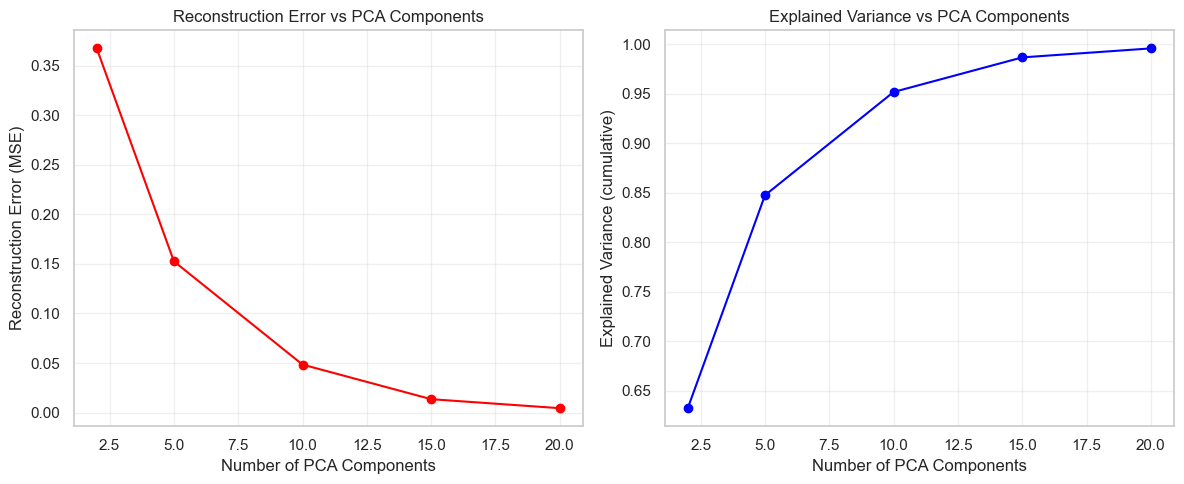

In [6]:
# Plots: reconstruction error and explained variance
plot_reconstruction_and_variance(
    results["n_components"],
    results["reconstruction_error"],
    results["explained_variance"],
)

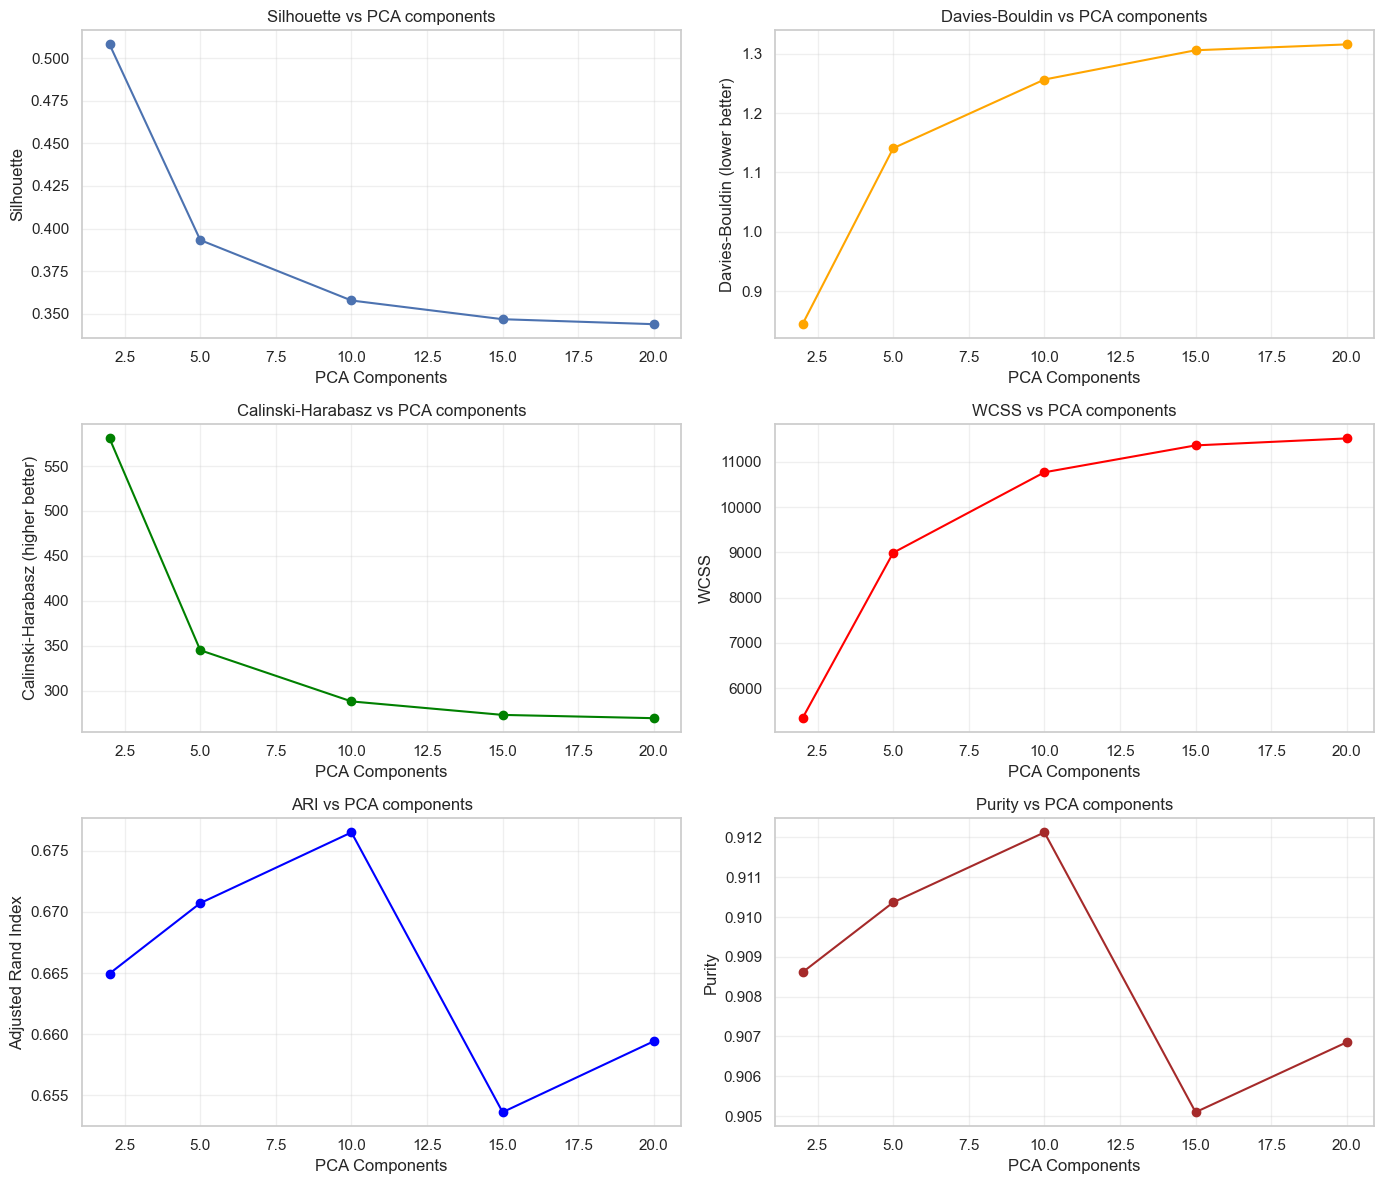

In [7]:
# Plots: clustering metrics across PCA dimensions
plot_clustering_metrics(results["n_components"], results)

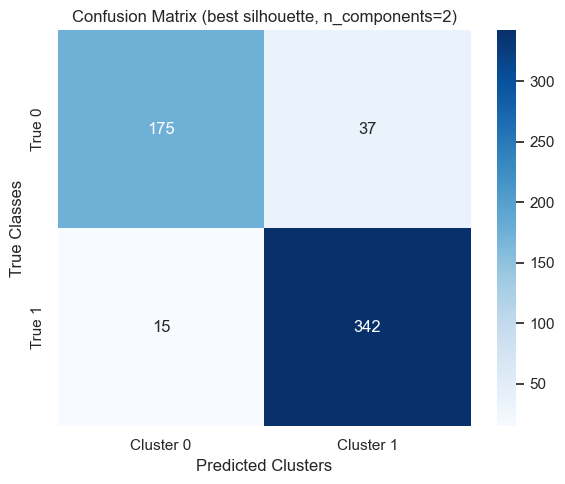

In [8]:
# Confusion matrix for best silhouette setup
title = f"Confusion Matrix (best silhouette, n_components={best_n})"
plot_confusion(cm, true_classes, pred_clusters, title)

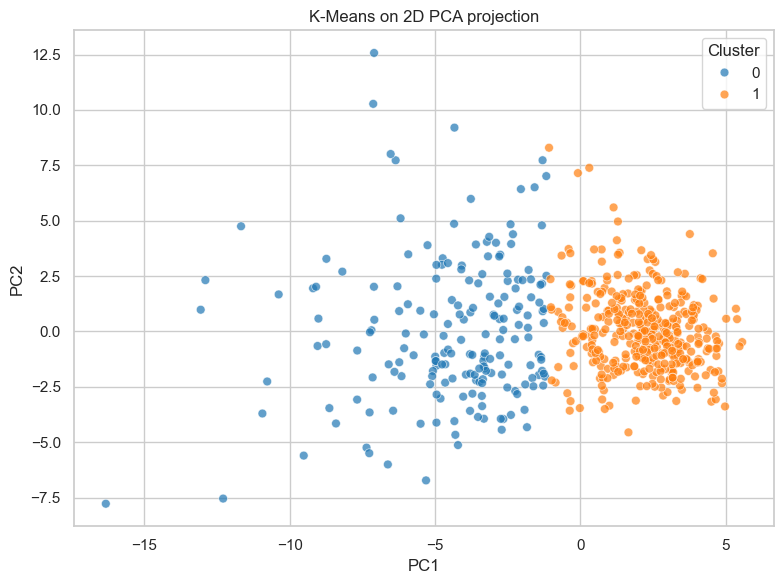

In [9]:
# 2D visualization when n_components includes 2
if 2 in n_components_list:
    pca2 = PCA(n_components=2)
    pca2.fit(X)
    X2 = pca2.transform(X)
    km2 = KMeans(k=2, init="kmeans++", max_iter=300, tol=1e-4)
    km2.fit(X2)
    plot_2d_projection(X2, km2.labels_, y_true)
else:
    print("n_components=2 not in list; skipping 2D projection.")